In [27]:
# !pip install pandas
import pandas as pd
data_set = 'Heart Dataset.csv'
data = pd.read_csv(data_set)

In [28]:
duplicate_rows = data.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_rows}")

data = data.drop_duplicates()

print(f"Number of rows after removing duplicates: {data.shape[0]}")

Number of duplicate rows: 273
Number of rows after removing duplicates: 917


In [29]:
missing_values = data.isnull().sum()
# print("Missing values per column:")
# print(missing_values)
data.shape
data.to_csv('Training_data', index=False)

SPLITTING THE DATASET FOR TRAINING

In [30]:
from sklearn.model_selection import train_test_split
import pandas as pd

# Check if your dataset is loaded properly
print("Dataset shape:", data.shape)

# Splitting the dataset into 70% training, 15% validation, 15% test
train_data, temp_data = train_test_split(data, test_size=0.3, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

print("Training data shape:", train_data.shape)
print("Validation data shape:", val_data.shape)
print("Test data shape:", test_data.shape)

# # Save the splits if needed
# train_data.to_csv('train_data.csv', index=False)
# val_data.to_csv('val_data.csv', index=False)
# test_data.to_csv('test_data.csv', index=False)

Dataset shape: (917, 9)
Training data shape: (641, 9)
Validation data shape: (138, 9)
Test data shape: (138, 9)


IMPORTING THE LIBRARIES FOR FINETUNING

In [31]:
# Import necessary libraries
# !pip install transformers

from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn as nn
from sklearn.metrics import classification_report


In [32]:
# Load the pretrained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [34]:
# Custom Dataset class for BERT
class HeartDiseaseDataset(Dataset):
    def __init__(self, data, tokenizer, max_len):
        self.data = data
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        # Extract row data
        row = self.data.iloc[index]
        # Combine columns for textual input (if applicable)
        text = f"Age: {row['age']}, Sex: {row['sex']}, Chest Pain Type: {row['chest pain type']}, " \
               f"Resting BP: {row['resting bp s']}, Cholesterol: {row['cholesterol']}, " \
               f"Fasting Blood Sugar: {row['fasting blood sugar']}, Max Heart Rate: {row['max heart rate']}, " \
               f"Exercise Angina: {row['exercise angina']}"

        # Tokenize the text
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        # Return tokenized data and label
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'label': torch.tensor(row['Final Target'], dtype=torch.long),
        }

In [35]:
# Define maximum token length
MAX_LEN = 512

# Create datasets
train_dataset = HeartDiseaseDataset(train_data, tokenizer, MAX_LEN)
val_dataset = HeartDiseaseDataset(val_data, tokenizer, MAX_LEN)
test_dataset = HeartDiseaseDataset(test_data, tokenizer, MAX_LEN)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

In [36]:
# Load a pretrained BERT model for classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model = model.to('cpu')  # Move the model to GPU if available

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [37]:
# # Define optimizer and loss function
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
loss_fn = nn.CrossEntropyLoss()
# from torch.optim import AdamW
# optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)

d:\Masters\Anaconda\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
# Training loop
#increase the epochs size for testing
EPOCHS = 3

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for batch in train_loader:
        input_ids = batch['input_ids'].to('cpu')
        attention_mask = batch['attention_mask'].to('cpu')
        labels = batch['label'].to('cpu')

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask)
        loss = loss_fn(outputs.logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch + 1}/{EPOCHS}, Loss: {total_loss / len(train_loader)}")

In [ ]:
# Evaluate on validation dataset
model.eval()
val_preds = []
val_labels = []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to('cpu')
        attention_mask = batch['attention_mask'].to('cpu')
        labels = batch['label'].to('cpu')

        outputs = model(input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)
        val_preds.extend(preds.cpu().numpy())
        val_labels.extend(labels.cpu().numpy())

print("Validation Results:")
print(classification_report(val_labels, val_preds))

Validation Results:
              precision    recall  f1-score   support

           0       0.74      0.87      0.80        55
           1       0.90      0.80      0.85        83

    accuracy                           0.83       138
   macro avg       0.82      0.83      0.82       138
weighted avg       0.84      0.83      0.83       138



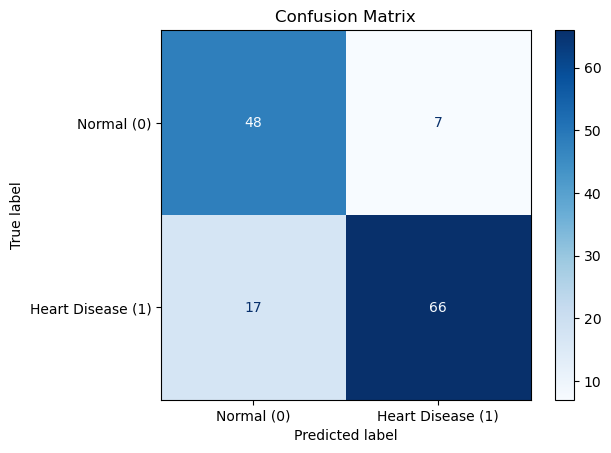

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Generate the confusion matrix
cm = confusion_matrix(val_labels, val_preds)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal (0)', 'Heart Disease (1)'])
disp.plot(cmap=plt.cm.Blues)

# Add title and labels
plt.title("Confusion Matrix")
plt.show()


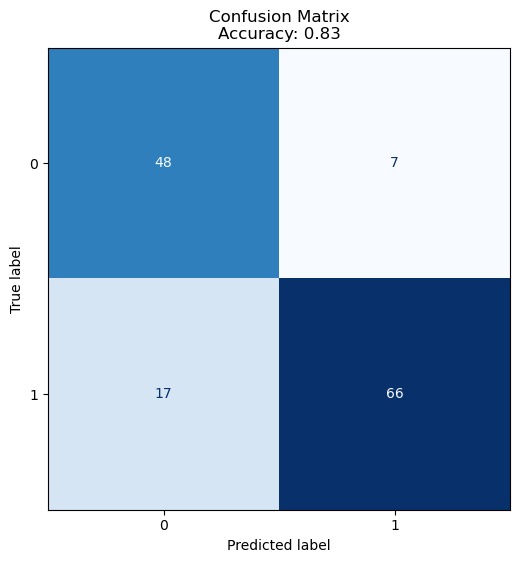

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Evaluate the model on the validation dataset
model.eval()
val_preds = []
val_labels = []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to('cpu')
        attention_mask = batch['attention_mask'].to('cpu')
        labels = batch['label'].to('cpu')   #cuda

        outputs = model(input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)
        val_preds.extend(preds.cpu().numpy())
        val_labels.extend(labels.cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(val_labels, val_preds)

# Confusion Matrix
cm = confusion_matrix(val_labels, val_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])

# Plot accuracy and confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues, ax=ax, colorbar=False)  # Disable separate colorbar for clarity
plt.title(f"Confusion Matrix\nAccuracy: {accuracy:.2f}")
plt.show()


PROMPTING